In [1]:
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

import polars as pl
import librosa
import librosa.display
import matplotlib.pyplot as plt
import helpers.input_processor as ip
import tqdm
import tensorflow as tf
from tensorflow.data import Dataset as tfds
import tensorflow_io as tfio
import math, random
import numpy as np

from matplotlib import pyplot as plt
import tensorflow.python.util as util

2022-08-16 08:07:39.983811: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import torch
import torchaudio
import polars as pl
import matplotlib.pyplot as plt
import os
import numpy as np
import tqdm
from torchaudio import transforms
from IPython.display import Audio
import math, random

import helpers.input_processor as ip

/home/tiaan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datetime import datetime
from packaging import version
# pip install -U tensorboard_plugin_profile

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-08-16 08:07:42.275586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 08:07:42.862386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [5]:
#load data from dataframe
data_dir = "data/raw_training/training_data/"
target_label = 'murmur_in_recording'
df = (
    ip.loadTrainingData(data_dir)
    .filter(pl.col(target_label) != 'Unknown')
    .pipe(ip.encodeData)
    .select([
        pl.col('audio_file').apply(lambda x: os.path.join(data_dir, x)),
        pl.col(target_label)
    ])
)

loading data from save file:  cache/ingested_data.json


In [6]:
#balance the data so that there is an equal number of murmur positive and murmur negative samples
#do this by duplicating random rows of whichever group (pos or neg) is smaller
neg_df = df.filter(pl.col(target_label)==0.0)
pos_df = df.filter(pl.col(target_label)==1.0)
numNeg = neg_df.height
numPos = pos_df.height

while numNeg != numPos:
    if numNeg < numPos:
        df.vstack(neg_df.sample(n=min(numPos-numNeg, neg_df.height), shuffle=True), in_place=True)
    else: 
        df.vstack(pos_df.sample(n=min(numNeg-numPos, pos_df.height), shuffle=True), in_place=True)
    numNeg = df.filter(pl.col(target_label)==0.0).height
    numPos = df.filter(pl.col(target_label)==1.0).height

#reshuffle rows
df = df.sample(frac=1.0, shuffle=True)

#check number of positive and negative samples
numNeg = df.filter(pl.col(target_label)==0.0).height
numPos = df.filter(pl.col(target_label)==1.0).height
print('Total Samples:       ', df.height)
print('Positive Samples:    ', numPos)
print('Negative Samples:    ', numNeg)
print('Percent Positive Samples:    ', numPos/(numPos+numNeg))


# method 2:

# #balance the data so that there is an equal number of murmur positive and murmur negative samples
# #do this by duplicating random rows of whichever group (pos or neg) is smaller
# neg_df = df.filter(pl.col(target_label)==0.0)
# pos_df = df.filter(pl.col(target_label)==1.0)
# numNeg = neg_df.height
# numPos = pos_df.height

# if numNeg < numPos:
#     df = neg_df.vstack(pos_df.sample(n=numNeg))
# elif numPos < numNeg:
#     df = pos_df.vstack(neg_df.sample(n=numPos))
# else:
#     df = neg_df.vstack(pos_df)

# #reshuffle rows
# df = df.sample(frac=1.0, shuffle=True)

# #check number of positive and negative samples
# numNeg = df.filter(pl.col(target_label)==0.0).height
# numPos = df.filter(pl.col(target_label)==1.0).height
# print('Total Samples:       ', df.height)
# print('Positive Samples:    ', numPos)
# print('Negative Samples:    ', numNeg)
# print('Percent Positive Samples:    ', numPos/(numPos+numNeg))

Total Samples:        5328
Positive Samples:     2664
Negative Samples:     2664
Percent Positive Samples:     0.5


In [7]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.plugin.tf as dali_tf

BATCH_SIZE = 64
NUM_EPOCHS = 50
H = 128
W = 313
DEVICE = 'gpu'

#prefetch_queue_depth=2*BATCH_SIZE, num_threads=4
@pipeline_def(device_id=0, batch_size=BATCH_SIZE)
def pipe(audioPaths, labels, device, sr=4000, duration=20, augmentData=True):
    # Load audio files
    encoded, labelsOut = fn.readers.file(files=audioPaths, labels=labels)
    audio, _ = fn.decoders.audio(encoded, sample_rate=sr)
    if device=='gpu':
        audio = audio.gpu()
        labelsOut = labelsOut.gpu()

    # Resize samples to uniform length, either by padding it with silence or truncating it
    trimmedSize = duration*sr
    audio = fn.slice(audio, 0, trimmedSize, axes=0, out_of_bounds_policy='pad')

    # Time shift signal to the left or right by a random percent of its original length (max 99%)
    #   NOT IMPLEMENTED 

    # Get mel spectrogram
    spec = fn.spectrogram(audio, device=device)
    melSpec = fn.mel_filter_bank(spec, sample_rate=sr, nfilter=128)
    melSpec = fn.to_decibels(melSpec, multiplier=10.0)

    if augmentData==True:
        # Apply time and frequency masking
        # maskValue = fn.reductions.mean(melSpec, device='cpu')
        maskValue = 0.
        melSpec = fn.erase(melSpec, axes=0, fill_value=maskValue, anchor=fn.random.uniform(range=(0.,1.)), shape=fn.random.uniform(range=(0.,0.1)), normalized=True, device=device)
        melSpec = fn.erase(melSpec, axes=1, fill_value=maskValue, anchor=fn.random.uniform(range=(0.,1.)), shape=fn.random.uniform(range=(0.,0.1)), normalized=True, device=device)
        normalized = fn.normalize(melSpec)
        samplesOut = normalized
    else:
        samplesOut = melSpec

    return samplesOut, labelsOut


In [8]:
# Split data into training, validation, and testing sets
train_df, test_df = ip.splitDataframe(df, split_ratio=0.9)
train_df, val_df = ip.splitDataframe(train_df, split_ratio=0.8)
numTrainBatches = math.ceil(train_df.height / BATCH_SIZE)
numValBatches = math.ceil(val_df.height / BATCH_SIZE)
numTestBatches = math.ceil(test_df.height / BATCH_SIZE)
print(f'Training Set Size, Batches:      {train_df.height}, {numTrainBatches}')
print(f'Validation Set Size, Batches:    {val_df.height}, {numValBatches}')
print(f'Testing Set Size, Batches:       {test_df.height}, {numTestBatches}')


with tf.device('/gpu:0' if DEVICE=='gpu' else '/cpu:0'):
    # Define shapes and types of the outputs
    shapes = ((BATCH_SIZE, H, W), (BATCH_SIZE))
    dtypes = (tf.float32, tf.int32)

    # Create pipelines
    train_pipe = pipe(audioPaths=train_df.get_column('audio_file').to_list(),
                    labels=train_df.get_column(target_label).to_list(),
                    device=DEVICE)
    val_pipe = pipe(audioPaths=val_df.get_column('audio_file').to_list(),
                    labels=val_df.get_column(target_label).to_list(),
                    device=DEVICE)            
    test_pipe = pipe(audioPaths=test_df.get_column('audio_file').to_list(),
                    labels=test_df.get_column(target_label).to_list(),
                    device=DEVICE)

    # Create datasets
    kwargs = dict(batch_size=BATCH_SIZE,
                  output_shapes=shapes,
                  output_dtypes=dtypes,
                  device_id=0,
                  prefetch_queue_depth=4,
                  num_threads=4,
                  exec_separated=True)
    train_set = dali_tf.DALIDataset(pipeline=train_pipe, **kwargs)
    val_set = dali_tf.DALIDataset(pipeline=val_pipe, **kwargs)
    test_set = dali_tf.DALIDataset(pipeline=test_pipe, **kwargs)


Training Set Size, Batches:      3836, 60
Validation Set Size, Batches:    959, 15
Testing Set Size, Batches:       533, 9


In [9]:

# train_pipe.build()
# train_pipe.save_graph_to_dot_file('DALIgraph2.dot', use_colors=True, show_ids=False, show_tensors=True)

In [10]:
#keras script

import numpy as np
from keras.models import Sequential
from keras import datasets, layers, models

with tf.device('/gpu:0' if DEVICE=='gpu' else '/cpu:0'):
    # Design model
    input_shape = (H, W, 1) # 128,313,1
    model = Sequential()

    # Arcitecture
    # model.add(layers.Conv2D(8, (3,3), activation='relu', input_shape=input_shape, padding='same'))
    # model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    # model.add(layers.Conv2D(16, (5,5), activation='relu'))
    # model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    # model.add(layers.Conv2D(32, (5,5), activation='relu'))
    # model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    # model.add(layers.Conv2D(64, (5,5), activation='relu'))
    # model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dense(1, activation='sigmoid'))



    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Dropout(0.2))
    # model.add(layers.Conv2D(256, (3,3), activation='relu'))
    # model.add(layers.MaxPool2D((2,2)))
    # model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))



    # model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
    # model.add(layers.Conv2D(16, (3,3), activation='relu'))
    # model.add(layers.MaxPool2D((2,2)))
    # model.add(layers.Dropout(0.2))
    # model.add(layers.Conv2D(32, (3,3), activation='relu'))
    # model.add(layers.Conv2D(32, (3,3), activation='relu'))
    # model.add(layers.MaxPool2D((2,2)))
    # model.add(layers.Dropout(0.5))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.5))
    # # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])
    model.summary()

    # # Create a TensorBoard callback
    # logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '10,15')

    # Train model on dataset
    history = model.fit(
        x=train_set,
        validation_data=val_set,
        epochs=NUM_EPOCHS,
        steps_per_epoch=int(numTrainBatches*0.9),
        validation_steps=int(numValBatches*0.9),
        # callbacks=tboard_callback
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 311, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 155, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 155, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 153, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 76, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 76, 64)        0

2022-08-16 08:07:45.908248: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-16 08:07:46.511097: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


54/54 [==============================] - 5s 39ms/step - loss: 0.7330 - accuracy: 0.5049 - val_loss: 0.6930 - val_accuracy: 0.5024
Epoch 2/50
54/54 [==============================] - 2s 36ms/step - loss: 0.6922 - accuracy: 0.5148 - val_loss: 0.6921 - val_accuracy: 0.5156
Epoch 3/50
54/54 [==============================] - 2s 35ms/step - loss: 0.6871 - accuracy: 0.5567 - val_loss: 0.6690 - val_accuracy: 0.5733
Epoch 4/50
54/54 [==============================] - 2s 36ms/step - loss: 0.6694 - accuracy: 0.5938 - val_loss: 0.6171 - val_accuracy: 0.6370
Epoch 5/50
54/54 [==============================] - 2s 35ms/step - loss: 0.6302 - accuracy: 0.6421 - val_loss: 0.6217 - val_accuracy: 0.6346
Epoch 6/50
54/54 [==============================] - 2s 35ms/step - loss: 0.5658 - accuracy: 0.6811 - val_loss: 0.5150 - val_accuracy: 0.7272
Epoch 7/50
54/54 [==============================] - 2s 35ms/step - loss: 0.5030 - accuracy: 0.7425 - val_loss: 0.4600 - val_accuracy: 0.7752
Epoch 8/50
54/54 [======

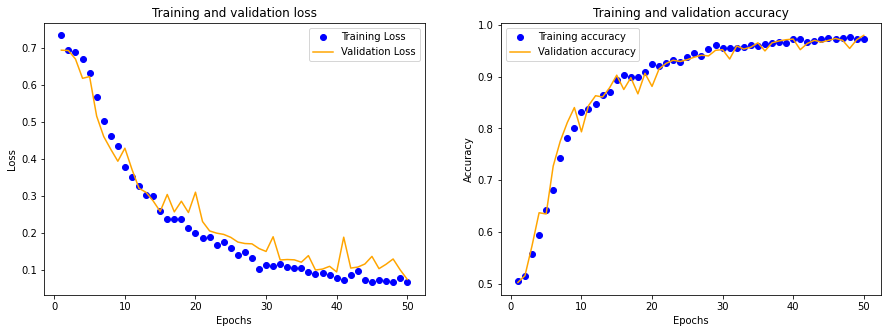

In [11]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,NUM_EPOCHS+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [12]:
model.evaluate(test_set, steps=numTestBatches)

9/9 [==============================] - 0s 11ms/step - loss: 0.0798 - accuracy: 0.9705


[0.07984355092048645, 0.9704861044883728]

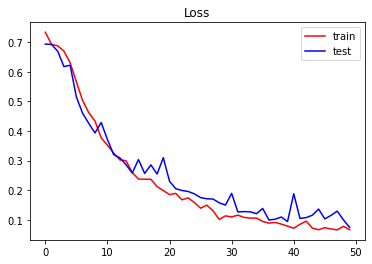

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train', color='red')
plt.plot(history.history['val_loss'], label='test', color='blue')
plt.legend()
plt.show()

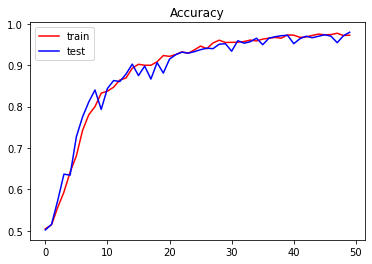

In [14]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train', color='red')
plt.plot(history.history['val_accuracy'], label='test', color='blue')
plt.legend()
plt.show()

In [15]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard


In [16]:
# Launch TensorBoard and navigate to the Profile tab to view performance profile
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 55615), started 10 days, 18:36:26 ago. (Use '!kill 55615' to kill it.)